In [271]:
import pandas as pd
import numpy  as np

In [272]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

In [273]:
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


## situação horrível de "azar" onde as classes estão ordenadas por padrão

In [274]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar     = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar     = dados_azar["vendido"]

dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [275]:
from sklearn.model_selection import cross_validate
from sklearn.dummy           import DummyClassifier


SEED = 301
np.random.seed(SEED)

In [276]:
modelo        = DummyClassifier()
results       = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media         = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [277]:
from sklearn.model_selection import cross_validate
from sklearn.tree            import DecisionTreeClassifier


SEED = 301
np.random.seed(SEED)

In [278]:
modelo        = DecisionTreeClassifier(max_depth=2)
results       = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media         = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


## Gerando dados aleatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

In [279]:
np.random.seed(SEED)

In [280]:
dados['modelo'] = dados['idade_do_modelo'] + np.random.randint(-2, 3, size=10000)
dados['modelo'] = dados['modelo'] + abs(dados['modelo'].min()) + 1

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [281]:
def imprime_resultados(results):
  media_treino  = results['train_score'].mean() * 100
  desvio_treino = results['train_score'].std()  * 100

  media_teste  = results['test_score'].mean() * 100
  desvio_teste = results['test_score'].std()  * 100

  print("[TREINO] ==> Acc média %.2f" % media_treino, end=", ")
  print("Intervalo [%.2f, %.2f]" % (media_treino - 2 * desvio_treino, media_treino + 2 * desvio_treino), end=", ")

  print("[TESTE] ==> Acc média %.2f" % media_teste, end=", ")
  print("Intervalo [%.2f, %.2f]" % (media_teste - 2 * desvio_teste, media_teste + 2 * desvio_teste))

  return media_treino, media_teste

## GroupKFold para analisar como o modelo se comporta com novos grupos

In [282]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

In [285]:
cv      = GroupKFold(n_splits=10)
modelo  = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

imprime_resultados(results)

[TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]


(75.79116856866345, 75.78421883757397)

## GroupKFold em um pipeline com StandardScaler e SVC

In [286]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm           import SVC
from sklearn.pipeline      import Pipeline


SEED = 301
np.random.seed(SEED)

In [288]:
scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([
  ('transformacao', scaler), 
  ('estimador', modelo)
])

cv      = GroupKFold(n_splits=10)
results = cross_validate(pipeline, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

imprime_resultados(results)

[TREINO] ==> Acc média 77.04, Intervalo [76.60, 77.48], [TESTE] ==> Acc média 76.68, Intervalo [74.28, 79.08]


(77.03673913585386, 76.67947835217086)

## Visualizando árvore

In [ ]:
import graphviz

from sklearn.tree import export_graphviz

In [289]:
cv      = GroupKFold(n_splits=10)
modelo  = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

imprime_resultados(results)

[TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]


(75.79116856866345, 75.78421883757397)

In [290]:
# Precisa treinar pq o cross validation treina varios modelos
modelo.fit(x_azar, y_azar)

features = x_azar.columns

dot_data = export_graphviz(
  modelo,
  out_file=None,
  filled=True,
  rounded=True,
  class_names=['Não', 'Sim'],
  feature_names=features
)

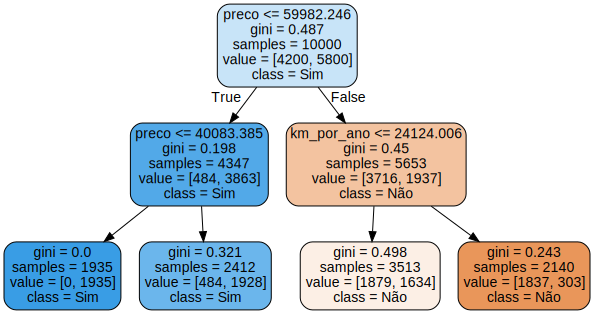

In [291]:
graph = graphviz.Source(dot_data)

graph

### `max_depth = 3`

[TREINO] ==> Acc média 78.75, Intervalo [78.49, 79.01], [TESTE] ==> Acc média 78.67, Intervalo [76.40, 80.94]


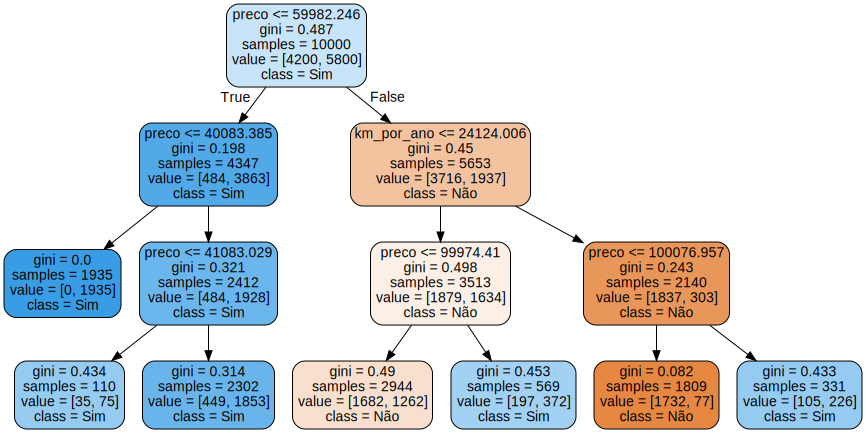

In [292]:
cv      = GroupKFold(n_splits=10)
modelo  = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

imprime_resultados(results)

modelo.fit(x_azar, y_azar)

features = x_azar.columns

dot_data = export_graphviz(
  modelo,
  out_file=None,
  filled=True,
  rounded=True,
  class_names=['Não', 'Sim'],
  feature_names=features
)

graph = graphviz.Source(dot_data)

graph

### `max_depth = 10`

[TREINO] ==> Acc média 81.15, Intervalo [80.74, 81.56], [TESTE] ==> Acc média 77.16, Intervalo [75.15, 79.18]


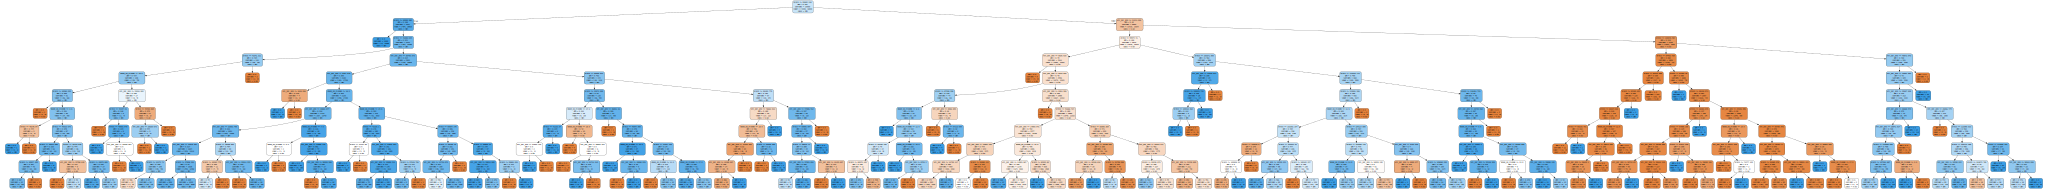

In [293]:
cv      = GroupKFold(n_splits=10)
modelo  = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

imprime_resultados(results)

modelo.fit(x_azar, y_azar)

features = x_azar.columns

dot_data = export_graphviz(
  modelo,
  out_file=None,
  filled=True,
  rounded=True,
  class_names=['Não', 'Sim'],
  feature_names=features
)

graph = graphviz.Source(dot_data)

graph

### Testando parâmetros

In [294]:
def roda_arvore(max_depth):
  cv      = GroupKFold(n_splits=10)
  modelo  = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

  print(f"max_depth: {max_depth}", end=", ")
  
  treino, teste = imprime_resultados(results)

  return [max_depth, treino, teste]

In [295]:
resultados = []

for i in range(1, 33):
  resultados.append(roda_arvore(i))

max_depth: 1, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 2, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 3, [TREINO] ==> Acc média 78.75, Intervalo [78.49, 79.01], [TESTE] ==> Acc média 78.67, Intervalo [76.40, 80.94]
max_depth: 4, [TREINO] ==> Acc média 78.79, Intervalo [78.53, 79.05], [TESTE] ==> Acc média 78.62, Intervalo [76.35, 80.89]
max_depth: 5, [TREINO] ==> Acc média 78.94, Intervalo [78.65, 79.23], [TESTE] ==> Acc média 78.54, Intervalo [76.35, 80.72]
max_depth: 6, [TREINO] ==> Acc média 79.17, Intervalo [78.83, 79.51], [TESTE] ==> Acc média 78.12, Intervalo [75.53, 80.72]
max_depth: 7, [TREINO] ==> Acc média 79.50, Intervalo [79.08, 79.92], [TESTE] ==> Acc média 77.97, Intervalo [75.76, 80.19]
max_depth: 8, [TREINO] ==> Acc média 79.89, Intervalo [79.50, 80.28], [TESTE] ==> Acc média 77.81, Intervalo [75.70, 79.92]
max_dept

In [296]:
resultados

[[1, 75.79116856866345, 75.78421883757397],
 [2, 75.79116856866345, 75.78421883757397],
 [3, 78.75099279906651, 78.67263337284332],
 [4, 78.78762769262194, 78.62271182864326],
 [5, 78.9410073693779, 78.53587138270534],
 [6, 79.17011453793069, 78.12326641953089],
 [7, 79.49680619886925, 77.97254806635326],
 [8, 79.88780998374749, 77.80792372999602],
 [9, 80.46345011791287, 77.38672276076734],
 [10, 81.15679496212813, 77.21265965153236],
 [11, 82.02472918156187, 76.97296430335066],
 [12, 82.8770410338166, 76.3583406757642],
 [13, 83.93817779261535, 76.03388324805444],
 [14, 85.03189628460576, 75.61204119319581],
 [15, 86.14309021449344, 75.27218793212597],
 [16, 87.1875611165165, 75.10822784179105],
 [17, 88.31533301427118, 74.73808945245605],
 [18, 89.27198866383776, 74.34190551360025],
 [19, 90.35656988800238, 74.29317912120827],
 [20, 91.30330837836377, 73.98837120294222],
 [21, 92.17543020118313, 73.99961696821407],
 [22, 93.04525416077404, 73.6535948887338],
 [23, 93.72658275314407,

In [297]:
resultados = pd.DataFrame(resultados, columns=["Max_Depth", "Treino", "Teste"])

In [298]:
resultados.head()

,Max_Depth,Treino,Teste
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.622712
4,5,78.941007,78.535871


In [299]:
import matplotlib.pyplot as plt
import seaborn          as sns

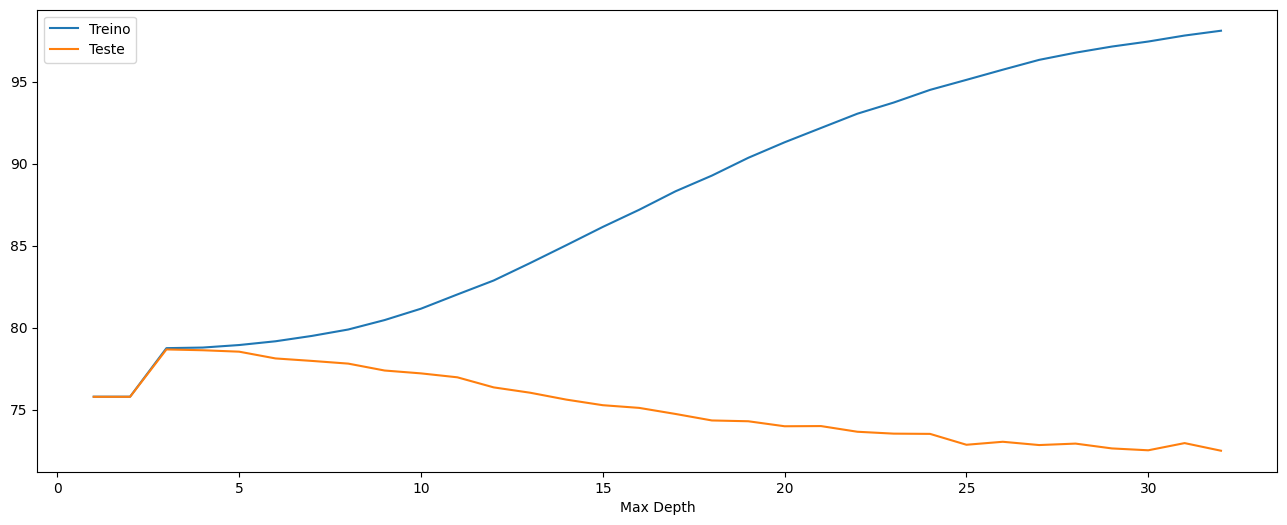

In [300]:
plt.figure(figsize=(16, 6))

plt.plot(resultados["Max_Depth"], resultados["Treino"])
plt.plot(resultados["Max_Depth"], resultados["Teste"])

plt.xlabel("Max Depth")

plt.legend(["Treino", "Teste"])
plt.show()

## Expplorando Hiperparâmetros em 2 dimensões

In [301]:
def roda_arvore(max_depth, min_samples_leaf):
  cv      = GroupKFold(n_splits=10)
  modelo  = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados['modelo'], return_train_score=True)

  print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}", end=", ")
  
  treino, teste = imprime_resultados(results)

  return [max_depth, min_samples_leaf, treino, teste]

In [302]:
from datetime import datetime

In [303]:
def busca():
  resultados = []

  start = datetime.now()

  for i in range(1, 33):
    for j in range(1, 33):
      resultados.append(roda_arvore(i, j))

  resultados = pd.DataFrame(resultados, columns=["Max_Depth", "Min_Samples_Leaf","Train", "Test"])

  end = datetime.now()
  print(f"\n\nTempo de busca: {end - start}")
  
  return resultados

In [304]:
resultados = busca()

max_depth: 1, min_samples_leaf: 1, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 2, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 3, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 4, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 5, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 6, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 7, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo 

In [305]:
resultados.corr().round(2)

,Max_Depth,Min_Samples_Leaf,Train,Test
Max_Depth,1.00,-0.00,0.68,-0.52
Min_Samples_Leaf,-0.00,1.00,-0.45,0.53
Train,0.68,-0.45,1.00,-0.76
Test,-0.52,0.53,-0.76,1.00


In [306]:
def busca():
  resultados = []

  start = datetime.now()

  for i in range(1, 33):
    for j in [32,64, 128, 256]:
      resultados.append(roda_arvore(i, j))

  resultados = pd.DataFrame(resultados, columns=["Max_Depth", "Min_Samples_Leaf","Train", "Test"])

  end = datetime.now()
  print(f"\n\nTempo de busca: {end - start}")
  
  return resultados

In [307]:
resultados = busca()

max_depth: 1, min_samples_leaf: 32, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 64, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 128, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 256, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 2, min_samples_leaf: 32, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 2, min_samples_leaf: 64, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 2, min_samples_leaf: 128, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, 

In [308]:
corr = resultados.corr()

corr.round(2)

,Max_Depth,Min_Samples_Leaf,Train,Test
Max_Depth,1.00,-0.00,0.54,-0.02
Min_Samples_Leaf,-0.00,1.00,-0.41,0.35
Train,0.54,-0.41,1.00,0.12
Test,-0.02,0.35,0.12,1.00


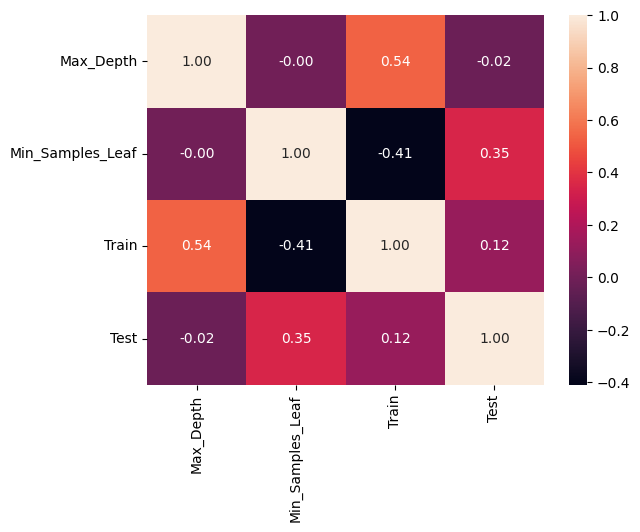

In [309]:
sns.heatmap(corr, annot=True, fmt=".2f")

plt.show()

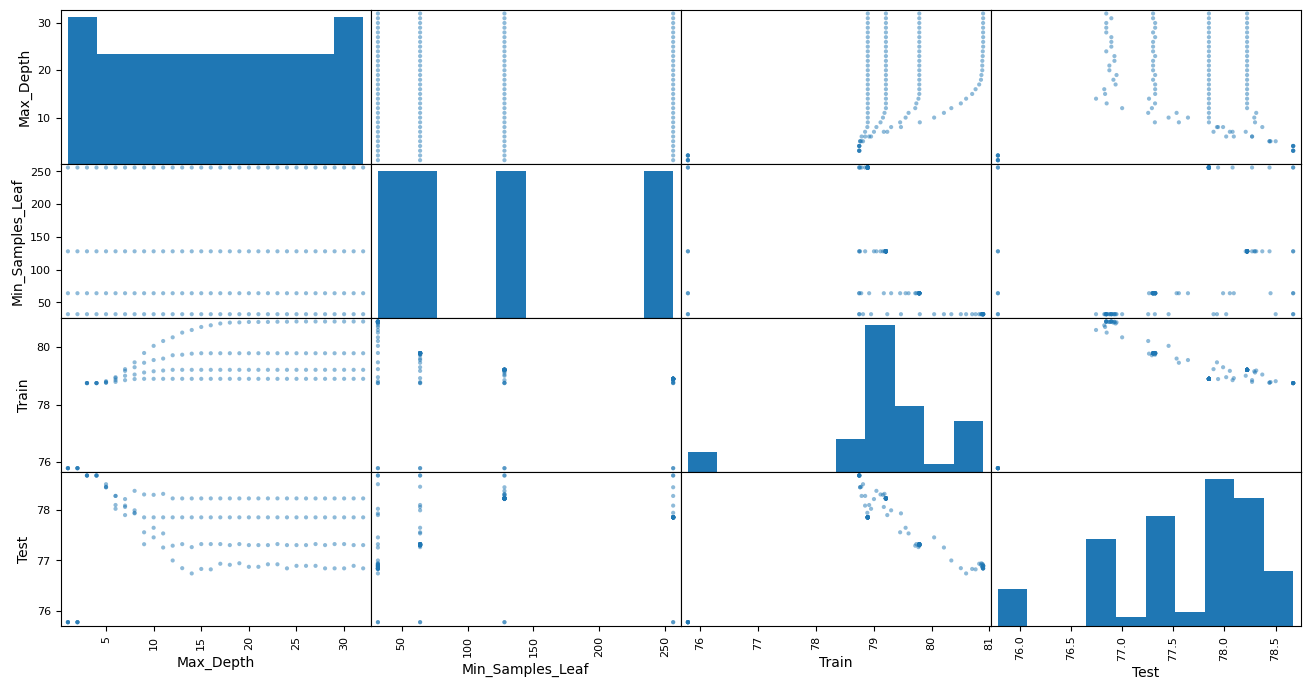

In [310]:
pd.plotting.scatter_matrix(resultados, figsize=(16, 8))

plt.show()

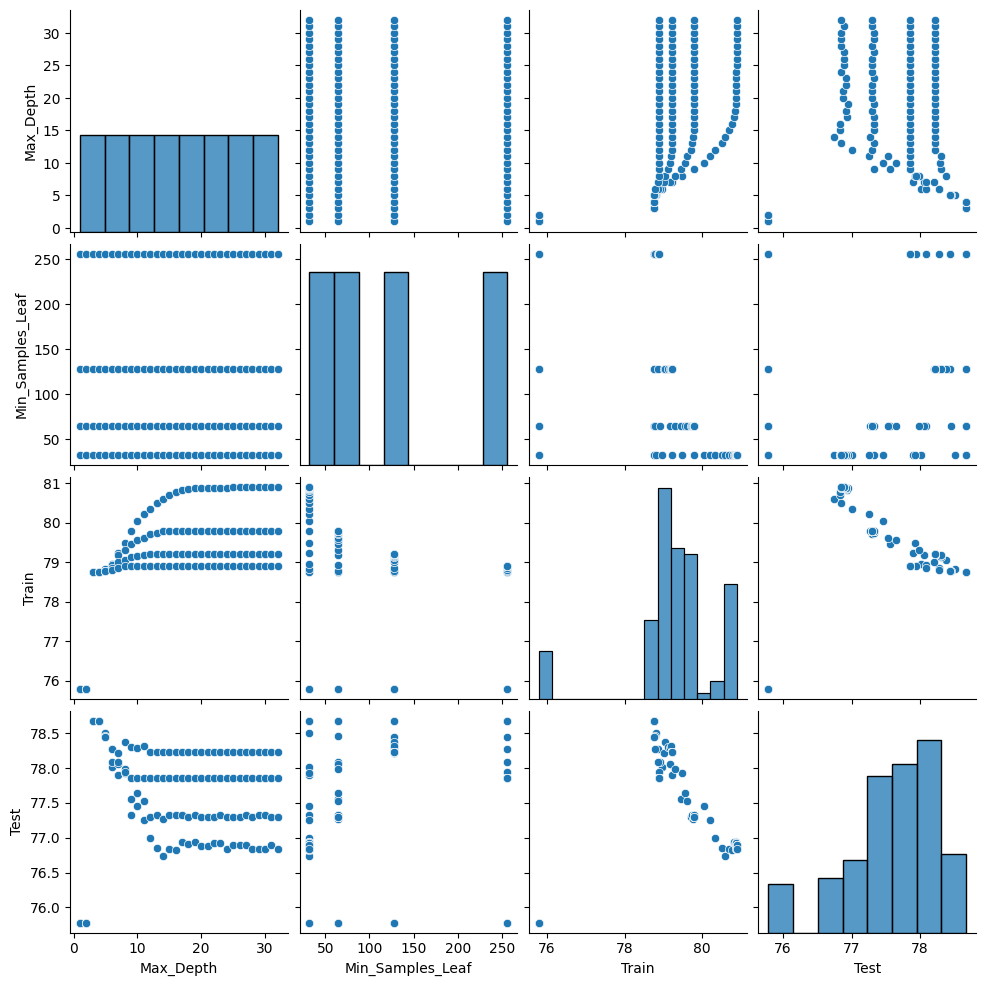

In [311]:
sns.pairplot(resultados)

plt.show()

In [312]:
def busca():
  resultados = []

  start = datetime.now()

  for i in range(1, 33):
    for j in [150, 170, 180, 200, 220, 240, 260]:
      resultados.append(roda_arvore(i, j))

  resultados = pd.DataFrame(resultados, columns=["Max_Depth", "Min_Samples_Leaf","Train", "Test"])

  end = datetime.now()
  print(f"\n\nTempo de busca: {end - start}")
  
  return resultados

In [313]:
resultados = busca()

max_depth: 1, min_samples_leaf: 150, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 170, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 180, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 200, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 220, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 240, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.78, Intervalo [73.67, 77.90]
max_depth: 1, min_samples_leaf: 260, [TREINO] ==> Acc média 75.79, Intervalo [75.56, 76.03], [TESTE] ==> Acc média 75.

In [314]:
resultados.sort_values("Test", ascending=False).head(15)

,Max_Depth,Min_Samples_Leaf,Train,Test
22,4,170,78.750993,78.672633
27,4,260,78.750993,78.672633
23,4,180,78.750993,78.672633
26,4,240,78.750993,78.672633
21,4,150,78.750993,78.672633
20,3,260,78.750993,78.672633
19,3,240,78.750993,78.672633
18,3,220,78.750993,78.672633
17,3,200,78.750993,78.672633
16,3,180,78.750993,78.672633


## Explorando 3 dimensões de hiperparâmetros

In [315]:
def roda_arvore(max_depth, min_samples_leaf, min_samples_split):
  cv      = GroupKFold(n_splits=10)
  modelo  = DecisionTreeClassifier(
    max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf, 
    min_samples_split=min_samples_split
  )
  results = cross_validate(
    modelo, x_azar, 
    y_azar, cv=cv, 
    groups=dados['modelo'], 
    return_train_score=True
  )

  media_treino = results['train_score'].mean() * 100
  media_teste  = results['test_score'].mean() * 100
  fit_time     = results['fit_time'].mean()
  score_time   = results['score_time'].mean()

  return [
    max_depth, 
    min_samples_leaf, 
    min_samples_split, 
    media_treino, 
    media_teste, 
    fit_time, 
    score_time
  ]

In [316]:
def busca():
  resultados = []

  for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        resultados.append(roda_arvore(max_depth, min_samples_leaf, min_samples_split))

  resultados = pd.DataFrame(resultados, columns=["Max_Depth", "Min_Samples_Leaf", "Min_Samples_Split", "Train", "Test", "Fit_Time", "Score_Time"])
  
  return resultados

In [317]:
resultados = busca()

In [318]:
corr = resultados.corr()

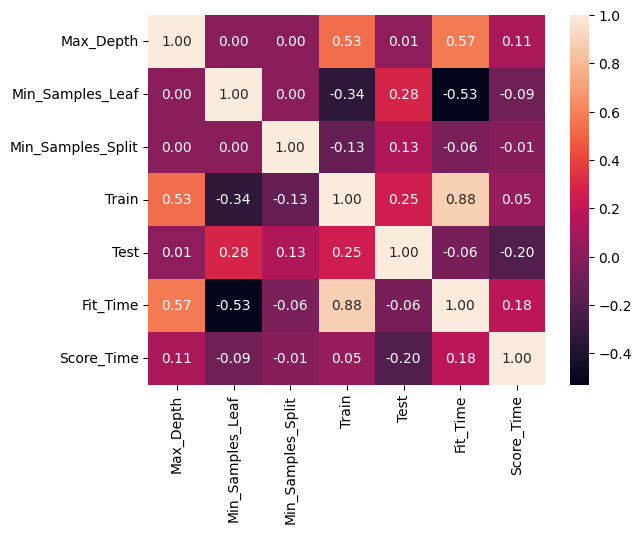

In [319]:
sns.heatmap(corr, annot=True, fmt=".2f")

plt.show()

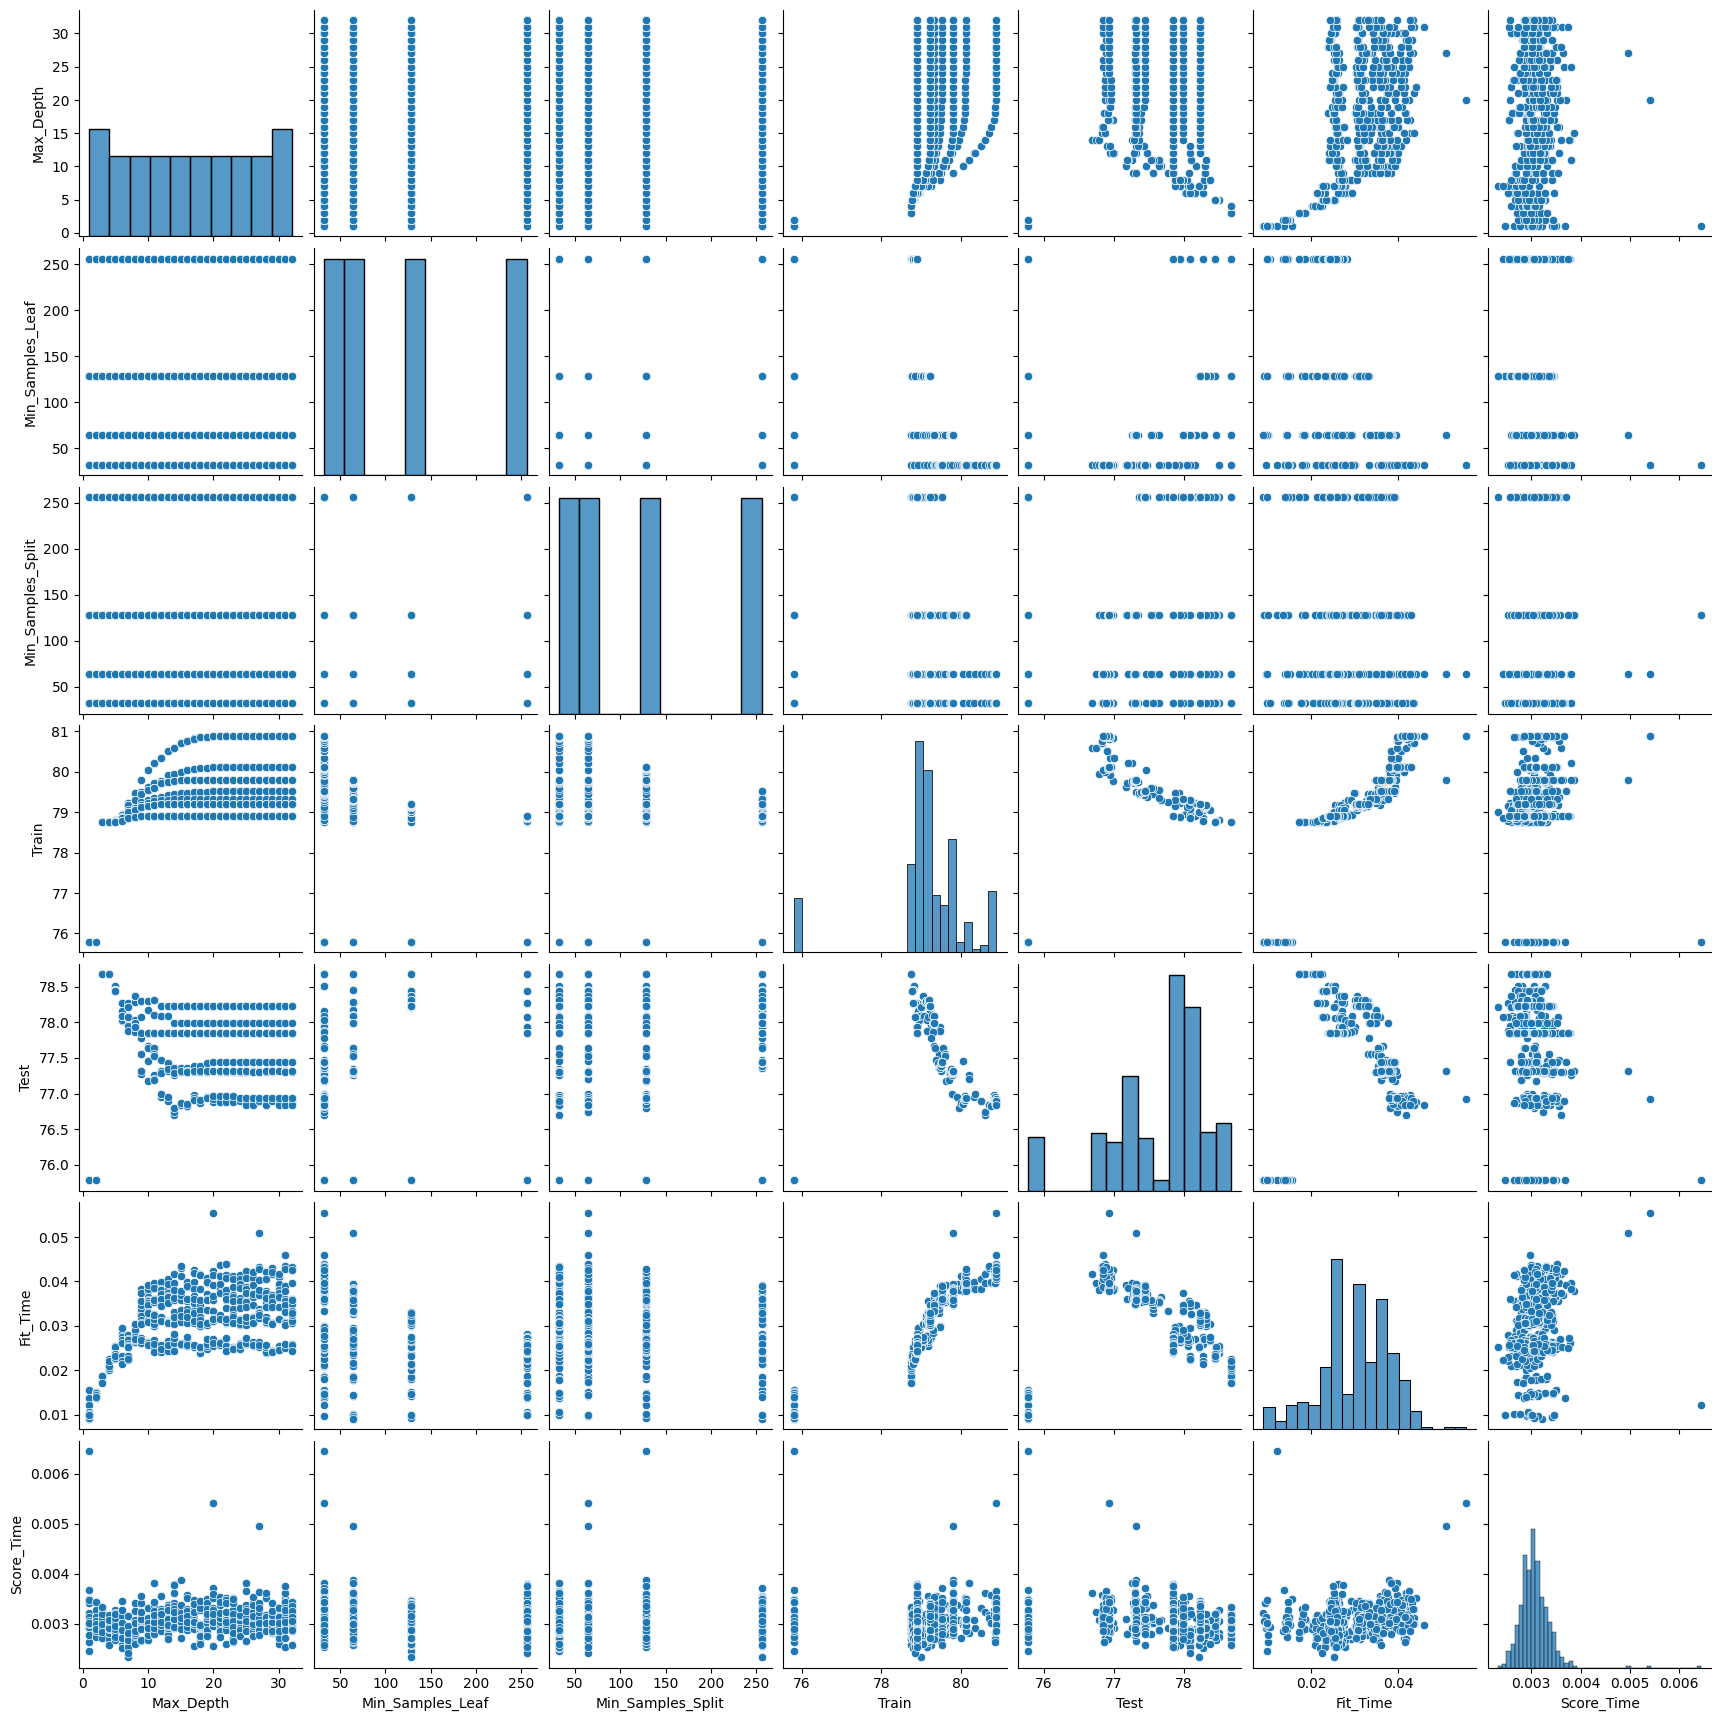

In [320]:
sns.pairplot(resultados)

plt.show()

In [321]:
resultados.sort_values("Test", ascending=False).head(20)

,Max_Depth,Min_Samples_Leaf,Min_Samples_Split,Train,Test,Fit_Time,Score_Time
62,4,256,128,78.750993,78.672633,0.020963,0.003063
44,3,256,32,78.750993,78.672633,0.017742,0.002994
32,3,32,32,78.750993,78.672633,0.017948,0.002856
33,3,32,64,78.750993,78.672633,0.018721,0.003067
34,3,32,128,78.750993,78.672633,0.018379,0.003078
35,3,32,256,78.750993,78.672633,0.017946,0.003111
36,3,64,32,78.750993,78.672633,0.018577,0.003092
37,3,64,64,78.750993,78.672633,0.017895,0.003098
38,3,64,128,78.750993,78.672633,0.018058,0.003234
39,3,64,256,78.750993,78.672633,0.018431,0.002893


## Usando o Sklearn para otimização

In [322]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

In [323]:
espaco_parametros = {
  'max_depth':         [3, 4],
  'min_samples_leaf':  [32, 64, 128],
  'min_samples_split': [32, 64, 128],
  'criterion':         ['gini', 'entropy']
}

In [324]:
busca = GridSearchCV(
  estimator=DecisionTreeClassifier(),
  param_grid=espaco_parametros,
  cv=GroupKFold(n_splits=10)
)

busca.fit(x_azar, y_azar, groups=dados['modelo'])

GridSearchCV(cv=GroupKFold(n_splits=10), estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
                         'min_samples_leaf': [32, 64, 128],
                         'min_samples_split': [32, 64, 128]})

In [325]:
resultados = pd.DataFrame(busca.cv_results_)

resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021726,0.002423,0.003615,0.000690,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.020106,0.001330,0.003450,0.001046,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.018762,0.000828,0.002999,0.000598,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.020095,0.001330,0.003516,0.001055,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.031482,0.012138,0.006214,0.003193,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [326]:
busca.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [327]:
busca.best_score_ * 100

78.67263337284332

In [328]:
melhor_modelo = busca.best_estimator_

melhor_modelo

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Evitar a seguinte abordagem, muito otimista

In [329]:
from sklearn.metrics import accuracy_score

In [330]:
pred = melhor_modelo.predict(x_azar)

accuracy_score(y_azar, pred) * 100

78.75

No caso de cross validation na busca por hiperparâmetros, fazemos mais cross validation. Chama-se Nasted Cross Validation

In [331]:
from sklearn.model_selection import cross_val_score

In [332]:
# Pandas com GroupKFold não está funcionando (bug)
# Não conseguimos prever o resultado para novos grupos

# scores = cross_val_score(
#   busca,
#   x_azar,
#   y_azar,
#   cv=GroupKFold(n_splits=10),
#   groups=dados['modelo']
# )

In [338]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

In [339]:
espaco_parametros = {
  'max_depth':         [3, 4],
  'min_samples_leaf':  [32, 64, 128],
  'min_samples_split': [32, 64, 128],
  'criterion':         ['gini', 'entropy']
}

In [341]:
busca = GridSearchCV(
  estimator=DecisionTreeClassifier(),
  param_grid=espaco_parametros,
  cv=KFold(n_splits=10, shuffle=True)
)

busca.fit(x_azar, y_azar)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
                         'min_samples_leaf': [32, 64, 128],
                         'min_samples_split': [32, 64, 128]})

In [345]:
resultados = pd.DataFrame(busca.cv_results_)

resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021366,0.002606,0.003995,0.001592,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78,...,0.799,0.801,0.797,0.757,0.771,0.812,0.793,0.7869,0.015681,1
1,0.020167,0.002705,0.003164,0.000515,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78,...,0.799,0.801,0.797,0.757,0.771,0.812,0.793,0.7869,0.015681,1
2,0.016913,0.001888,0.002613,0.000639,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78,...,0.799,0.801,0.797,0.757,0.771,0.812,0.793,0.7869,0.015681,1
3,0.016210,0.001163,0.002690,0.000491,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78,...,0.799,0.801,0.797,0.757,0.771,0.812,0.793,0.7869,0.015681,1
4,0.019932,0.004512,0.003231,0.000663,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78,...,0.799,0.801,0.797,0.757,0.771,0.812,0.793,0.7869,0.015681,1


In [342]:
scores = cross_val_score(
  estimator=busca,
  X=x_azar,
  y=y_azar,
  cv=KFold(n_splits=10, shuffle=True)
)

In [343]:
scores

array([0.771, 0.794, 0.782, 0.794, 0.81 , 0.782, 0.775, 0.792, 0.782,
       0.786])

In [346]:
len(scores) #n_splits

10

In [347]:
def imprime_scores(scores):
  media  = scores.mean() * 100
  desvio = scores.std()  * 100

  print("Acc média %.2f" % media, end=", ")
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio), end=", ")

In [348]:
imprime_scores(scores)

Acc média 78.68, Intervalo [76.56, 80.80], 

In [349]:
melhor_modelo = busca.best_estimator_

melhor_modelo

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

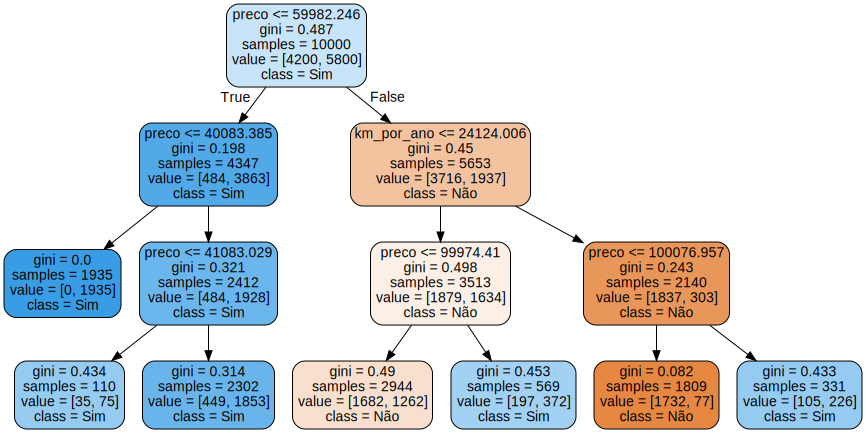

In [350]:
features = x_azar.columns

dot_data = export_graphviz(
  melhor_modelo,
  out_file=None,
  filled=True,
  rounded=True,
  class_names=['Não', 'Sim'],
  feature_names=features
)

graph = graphviz.Source(dot_data)

graph